# Testing the difference between $Q^*$ and $Q^{**}$

On 12/15/2022 Dhruv and I developed some nice framework to attribute $Q^*$ to mechanisms (fill in). 

For that to hold we need to assume that $Q^* \approx Q^{**}$. 

**Is that the case?**

In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
import json
import gcsfs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scale_aware_air_sea.utils import scale_separation, smooth_inputs_dataset
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26
from dask.diagnostics import ProgressBar


# for now use old output (the new one is running at the moment)
# set up gcs filesystem
# 👇 replace with your key 
with open('/home/jovyan/KEYS/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)

fs_leap = gcsfs.GCSFileSystem()

In [3]:
ds_ref = load_and_combine_cm26(fs_leap)
# make a wet mask
wet_mask = ~np.isnan(ds_ref['surface_temp'].isel(time=0))

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


In [4]:
ds = xr.open_dataset(fs.get_mapper('ocean-transport-group/scale-aware-air-sea/flux-output/cm26_split_full_v4.1.zarr'), engine='zarr', chunks={})

In [5]:
ds_full, ds_large_scale, ds_small_scale = scale_separation(ds, 50, wet_mask)

q_star = ds_small_scale.sel(smoothing='smooth_all')
q_star_star = smooth_inputs_dataset(q_star, ['xt_ocean', 'yt_ocean'], 50)

In [6]:
from dask.distributed import Client
client = Client()
client

# # distributed does not like these long tasks (>40s) we produce. 
# # Lets see if we can tune that (!YES!):
# import dask
# dask.config.set(
#     {
#         "distributed.comm.timeouts.tcp": "360s",
#         "distributed.comm.timeouts.connect": "360s",
#     }
# )

# from dask_gateway import Gateway
# gateway = Gateway()


# options = gateway.cluster_options()
# options.worker_memory = 50 # Could proabably reduce this to something like 40, but I think that doesnt actually free up space...
# options.worker_cores = 12 # could probably handle 12 here...

# options.environment = dict(
#     DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
# )

# # Create a cluster with those options
# cluster = gateway.new_cluster(options)
# client = cluster.get_client()
# cluster.scale(200)
# client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/air_sea_project/proxy/8787/status,
Dashboard: /user/jbusecke/air_sea_project/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 58.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44737,Workers: 4
Dashboard: /user/jbusecke/air_sea_project/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.87 GiB
Comm: tcp://127.0.0.1:35181,Total threads: 4
Dashboard: /user/jbusecke/air_sea_project/proxy/34193/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:45309,


In [7]:
# load some test data for faster analysis
tt = slice(0,3)
q_star_test = q_star.isel(time=tt, algo=0).load()
q_star_star_test = q_star_star.isel(time=tt, algo=0).load()

In [20]:
difference = q_star_star_test - q_star_test

## Plotting

Text(0.5, 1.0, '$Q^{**} - Q^{*}$')

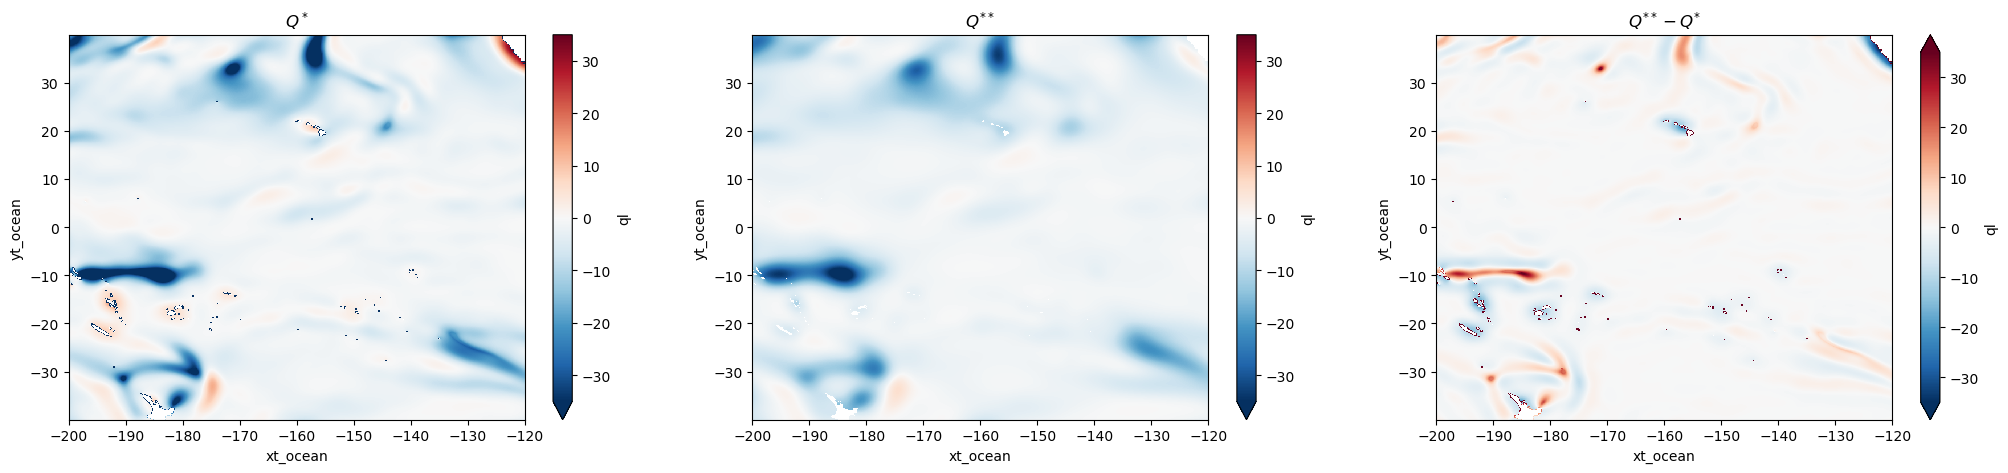

Task exception was never retrieved
future: <Task finished name='Task-113850' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2054> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2063, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-113851' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2054> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2063, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-113852' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/py

In [59]:
import matplotlib.pyplot as plt

iroi = dict(time=1)
roi = dict(xt_ocean=slice(-200, -120), yt_ocean=slice(-40, 40))
kwargs = dict(x='xt_ocean', vmax=35)

plt.figure(figsize=[25, 5])
plt.subplot(1,3,1)
q_star_test['ql'].isel(**iroi).sel(**roi).plot(**kwargs)
plt.title('$Q^*$')

plt.subplot(1,3,2)
q_star_star_test['ql'].isel(**iroi).sel(**roi).plot(**kwargs)
plt.title('$Q^{**}$')

plt.subplot(1,3,3)
difference['ql'].isel(**iroi).sel(**roi).plot(**kwargs)
plt.title('$Q^{**} - Q^{*}$')

In [29]:
rel_difference = difference / abs(q_star_test)

In [35]:
q_star_star_test['ql']

<xarray.DataArray 'ql' (time: 3, xt_ocean: 3600, yt_ocean: 2700)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    algo       <U8 'ncar'
    smoothing  <U23 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0181-01-03 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    filter_scale:  50

In [36]:
q_star_star['ql']

,Array,Chunk
Bytes,793.54 GiB,111.24 MiB
Shape,"(3, 7305, 3600, 2700)","(1, 3, 3600, 2700)"
Count,169 Graph Layers,7305 Chunks
Type,float32,numpy.ndarray


In [48]:
from xhistogram.xarray import histogram
bins = np.linspace(-50, 50, 100)
x = q_star_star_test['ql']
x.name = 'qstar_star'
y = q_star_test['ql']
y.name = 'qstar'
hist = histogram(x, y, bins=bins, dim=['xt_ocean', 'yt_ocean'])

In [50]:
import numpy as np

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


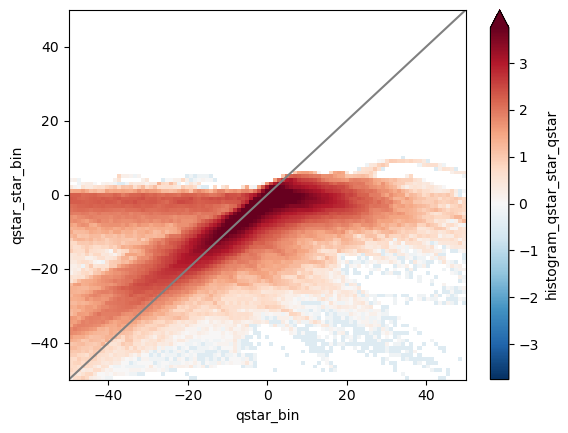

In [52]:
np.log10(hist.mean('time')).plot(robust=True)
plt.plot(bins, bins, color='0.5')